# Scraping Wikipedia Page
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(website_url,'lxml')

### Scraping table from wikipedia

In [3]:
table = soup.find('table',{'class':'wikitable sortable'})

In [4]:
A=[]
B=[]
C=[]

for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))


In [5]:
df=pd.DataFrame()
df['Postcode']=A
df['Borough']=B
df['Neighbourhood']=C

In [6]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Ignoring cells with not assigned values

In [7]:
df1=df[df.Borough != 'Not assigned']

In [8]:
df1=df1.reset_index(drop=True)

In [9]:
df1.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


### Merging Neighbourhood with same Postcode

In [10]:
index_cols = df1.columns.tolist()
index_cols.remove("Neighbourhood")
df2=df1.groupby(index_cols)["Neighbourhood"].apply(list)
df2=df2.reset_index()

In [11]:
Neighbourhood=[]
for i in range(103):
    s=df2['Neighbourhood'][i]
    line = ', '.join([str(elem) for elem in s]).replace('\n','')
    Neighbourhood.append(line)

In [12]:
df2['Neighbourhood']=Neighbourhood

In [13]:
df2.head(6)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village


### 'Not assigned' Neighbourhood to corresponding Borough

In [14]:
df2.Neighbourhood[df2.Neighbourhood == 'Not assigned']=df2.Borough[df2.Neighbourhood == 'Not assigned']

### Required Dataframe and it's Shape

In [15]:
df2.head(6)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village


In [16]:
df2.shape

(103, 3)

### Adding Latitude and Longitudes

In [17]:
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [18]:
lat_long=pd.read_csv('Geospatial_Coordinates.csv')

In [19]:
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
df2['Latitude']=lat_long['Latitude']
df2['Longitude']=lat_long['Longitude']

### Final DataFrame

In [21]:
df2.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Plotting the Neighbourhoods on map

In [22]:
import folium 

In [23]:
canada_map = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

In [24]:
incidents = folium.map.FeatureGroup()

for lat, lng,neigh in zip(df2['Latitude'],df2['Longitude'],df2['Neighbourhood']):
    incidents.add_child(
        folium.features.Marker(
            [lat, lng],
            popup=neigh,
        )
    )

# add incidents to map
canada_map.add_child(incidents)

### Count of Neighbourhoods in each borough

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'Count of Neighbourhoods in Each Borough')

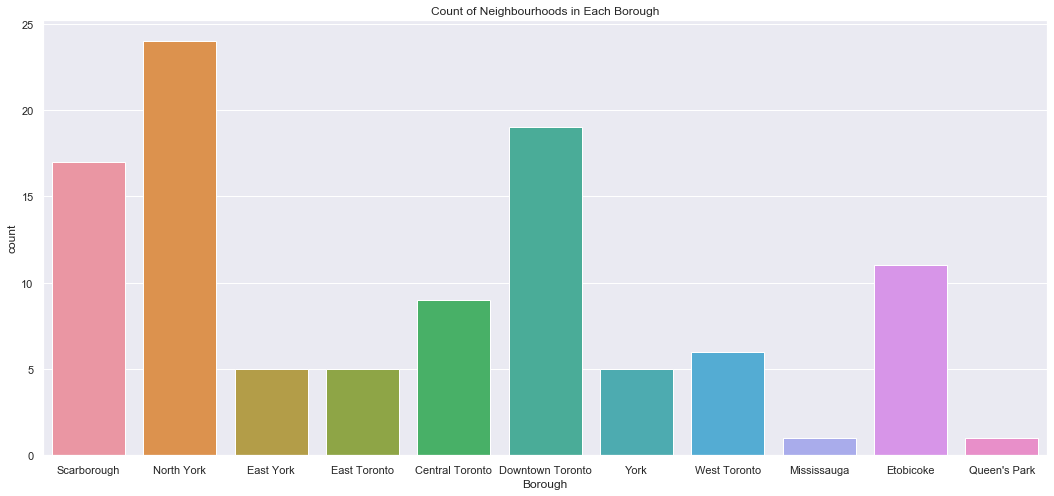

In [26]:
plt.figure(figsize=(18,8))
sns.countplot(x="Borough", data=df2).set_title("Count of Neighbourhoods in Each Borough")